<a href="https://colab.research.google.com/github/eeuuais/studypolio/blob/main/Pytorch_prac/(pytorch)recommedation_movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Download movielens data

In [80]:
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip",'movielens.zip')
zip_ref = zipfile.ZipFile('movielens.zip','r')
zip_ref.extractall()
print('Done. Dataset contains')
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains
b'943 users\n1682 items\n100000 ratings\n'


In [81]:
# 사용자에 대한 인적정보
user_cols = ['user_id','age','sex','occupation','zip_code']
users = pd.read_csv('ml-100k/u.user',sep='|', names=user_cols,encoding='latin-1')
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [82]:
# 사용자 - 아이템에 대한 평가 UV(T)
rating_cols =['user_id','movie_id','rating','unix_timestemp']
ratings = pd.read_csv('ml-100k/u.data',sep='\t',names=rating_cols,encoding='latin-1')
ratings.head()

,user_id,movie_id,rating,unix_timestemp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [83]:
# 아이템에대한 정보(장르)
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movie_cols = ['movie_id','title','release_date','video_release_data','imdb_url']+genre_cols
movies = pd.read_csv('ml-100k/u.item',sep='|',names=movie_cols,encoding='latin-1')
movies = movies.drop(columns=['video_release_data','imdb_url'])
movies.head()

,movie_id,title,release_date,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [84]:
# scikit learn - one_hot encoding 같은 부분 이용하기 위한 Tool: Label encoding
# scikit learn - train_test_split: 학습-운용 데이터셋 분류

user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()

# 정규화 하기위한 정보 --> 정규화 복원  1~5 등급 --> 0~1 숫자 변환
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users,n_movies,min_rating,max_rating

(943, 1682, 1.0, 5.0)

In [85]:
movies['title'][64]

"What's Eating Gilbert Grape (1993)"

In [86]:
# 학습-운영용 데이터셋 분류

X = ratings[['user','movie']].values 
Y = ratings['rating'].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2) # scikit learn (20% test)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print(X_train[0])

(80000, 2) (20000, 2) (80000,) (20000,)
[ 698 1056]


# dataset

In [87]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x = torch.LongTensor(x) 
        self.y = torch.Tensor(y)
        
    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.x)

In [88]:
train_dataset = dataset(X_train,Y_train)
test_dataset = dataset(X_test,Y_test)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False,drop_last=False)

## Making recommender system model

In [89]:
n_factors = 64
class Recommender_model(nn.Module):
    def __init__(self):
        super(Recommender_model,self).__init__()
        self.emb1 = nn.Embedding(n_users,n_factors)
        self.emb2 = nn.Embedding(n_movies,n_factors)
        self.lin1 = nn.Linear(2*n_factors,1) # 128*1 weight matrix

    def forward(self,x):
        user,item = x[:,0].view(-1,1), x[:,1].view(-1,1)
      
        user = self.emb1(user)
        user = user.view(-1,n_factors)

        item = self.emb2(item)
        item = item.view(-1,n_factors)

        con = torch.cat([user,item],dim=-1) # user, item 붙여줌
        value = F.sigmoid(self.lin1(con)) # 정규화 0~1

        value = value * (max_rating - min_rating) + min_rating # 정규화 복원 1~5
        return value

In [90]:
# 학습방법
model = Recommender_model().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-05)

criterion = nn.MSELoss() # mean((y-y^)**2)

train_loss_trend,test_loss_trend = [],[]
for ep in range(300):
  avg_loss = 0 
  # training
  for x,y in train_loader:
    x = x.to(device)
    y = y.to(device)
    y_infer = model(x)
    loss = criterion(y_infer,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
  train_loss_trend.append(avg_loss/len(train_loader))
  
  if ep % 10 == 0:
    print('Epoch: {:d}, Train loss: {:f}'.format(ep,avg_loss/len(train_loader)))
  
  # test -- 학습하지 X
  avg_loss = 0
  for x,y in test_loader:
    x = x.to(device)
    y = y.to(device)
    y_infer = model(x)
    loss = criterion(y_infer,y)
    avg_loss += loss.item()
  test_loss_trend.append(avg_loss/len(test_loader))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Train loss: 1.310199


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10, Train loss: 1.267195
Epoch: 20, Train loss: 1.267319
Epoch: 30, Train loss: 1.267227
Epoch: 40, Train loss: 1.267167
Epoch: 50, Train loss: 1.267268
Epoch: 60, Train loss: 1.267261
Epoch: 70, Train loss: 1.267190
Epoch: 80, Train loss: 1.267253
Epoch: 90, Train loss: 1.267218
Epoch: 100, Train loss: 1.267275
Epoch: 110, Train loss: 1.267282
Epoch: 120, Train loss: 1.267219
Epoch: 130, Train loss: 1.267223
Epoch: 140, Train loss: 1.267263
Epoch: 150, Train loss: 1.267274
Epoch: 160, Train loss: 1.267181
Epoch: 170, Train loss: 1.267282
Epoch: 180, Train loss: 1.267270
Epoch: 190, Train loss: 1.267266
Epoch: 200, Train loss: 1.267277
Epoch: 210, Train loss: 1.267212
Epoch: 220, Train loss: 1.267211
Epoch: 230, Train loss: 1.267240
Epoch: 240, Train loss: 1.267334
Epoch: 250, Train loss: 1.267230
Epoch: 260, Train loss: 1.267244
Epoch: 270, Train loss: 1.267303
Epoch: 280, Train loss: 1.267255
Epoch: 290, Train loss: 1.267254


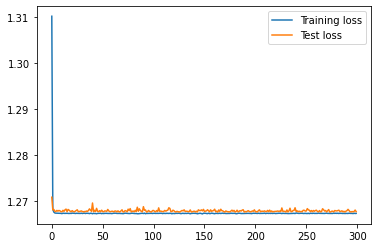

In [91]:
plt.plot(train_loss_trend, label = 'Training loss')
plt.plot(test_loss_trend, label = 'Test loss')
plt.legend()

## Test dataset

In [93]:
# check

user_number = 0 # 1000번째 user의 영화등급
user, movie = X_test[user_number][0], X_test[user_number][1]
favor = Y_test[user_number]
inference = model(torch.LongTensor(X_test[user_number].reshape(-1, 2)).to(device)).detach().cpu().numpy().squeeze()

print('유저번호', user)
print('영화제목', movies['title'][movie])
print('실제 선호도', favor)
print('예측 선호도', inference)
print('Distance {}'.format((favor-inference)**2))

유저번호 342
영화제목 Jurassic Park (1993)
실제 선호도 5.0
예측 선호도 3.5393465
Distance 2.133508774058157
